In [1]:
# Load the libraries
import pandas as pd
import numpy  as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import warnings
import platform
import sys
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore")

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#import the training data and test data pickles 
train_df = pd.read_pickle("train_df.pickle")
test_df  = pd.read_pickle("test_df.pickle")

#get the training std 
trainrtt_mean = train_df['last_rtt'].mean()
trainrtt_std = train_df['last_rtt'].std()

In [3]:
# Choose your features and target
cols_dropped = ['date','last_rtt','normalizzed_rtt','src_names']

X_train = train_df.drop(columns=cols_dropped, axis=1)
y_train = train_df['normalizzed_rtt']

X_test = test_df.drop(columns=cols_dropped, axis=1)
y_test = test_df['normalizzed_rtt'] 


In [4]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)


In [5]:
#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Flatten
import os
os.environ['TF_METAL_DEVICE'] = '1'

In [6]:
# split a univariate sequence into samples
from numpy import array

def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [7]:
n_steps = 100

Xtrain_3d = split_sequence(X_train[:10000],n_steps)
Xtest_3d = split_sequence(X_test[:10000],n_steps)
Xtrain_3d.shape

(9900, 100, 50)

In [8]:
n_features = Xtrain_3d.shape[2]
Xtrain_3d  = Xtrain_3d .reshape((Xtrain_3d.shape[0], Xtrain_3d.shape[1], n_features))
Xtest_3d = Xtest_3d .reshape((Xtest_3d.shape[0], Xtest_3d.shape[1], n_features))
Xtrain_3d[0].shape

(100, 50)

In [9]:
# define model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
model.add(LSTM(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Define RMSprop optimizer with your desired learning rate
optimizer = RMSprop(learning_rate=0.0001)

# Compile your model using the RMSprop optimizer
model.compile(optimizer=optimizer, loss='mse')


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)           │     29,440 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)               │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 128)               │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 139,137 (543.50 KB)

 Trainable params: 138,881 (542.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
# fit model
model.fit(Xtrain_3d,y_train[0:len(Xtrain_3d)],epochs=20, verbose=0)

In [12]:
# https://stackoverflow.com/questions/66080745/keras-model-predicts-nan
X_test_tensor = tf.convert_to_tensor(Xtest_3d, dtype=tf.int64) 
y_pred = model.predict(X_test_tensor, verbose=0)
y_pred

array([[-1.3332319],
       [-1.3601904],
       [-1.3506951],
       ...,
       [-1.3006227],
       [-1.3001871],
       [-1.3003039]], dtype=float32)

In [13]:
#loss function for LSTM
from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(y_test[0:len(y_pred)], y_pred))
lstm_drmse = lstm_rmse * trainrtt_std

print(f'RMSE for LSTM: ', lstm_rmse, 'Denormalied RMSE: ', lstm_drmse)

RMSE for LSTM:  0.4026452514258405 Denormalied RMSE:  3.7615327378739862


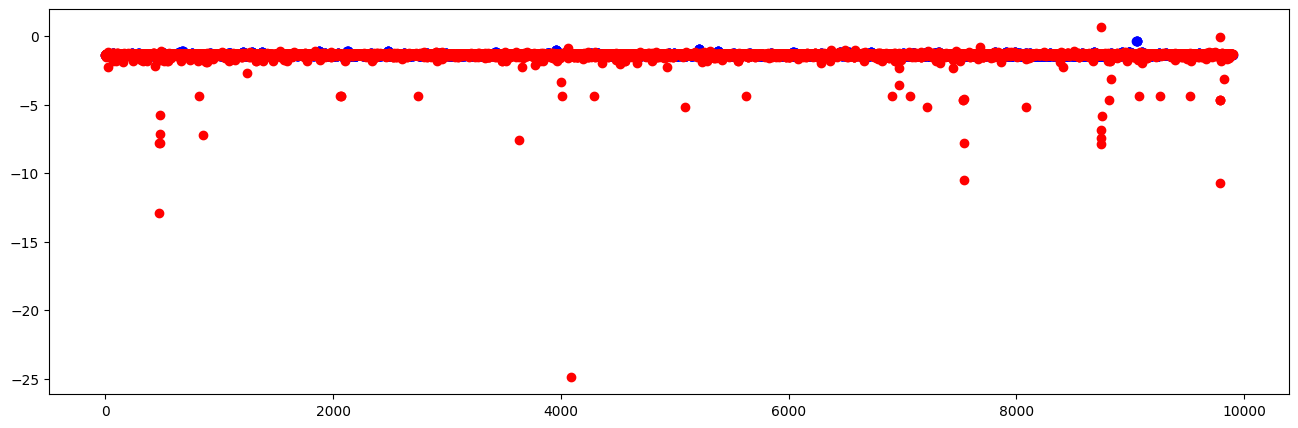

In [14]:
#plot actual vs predicted
plt.scatter(range(len(y_test[0:len(y_pred)])), y_test[0:len(y_pred)], color='blue')
plt.scatter(range(len(y_pred)), y_pred, color='red')